In [2]:
# Re-import all necessary libraries and reload data after kernel reset
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the cleaned data
file_path = "cleandata.csv"
df_clean = pd.read_csv(file_path)

# Process date and sort
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')

# Define target
target = 'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)'

# Add lag and rolling features
df_clean['spot_rate_lag_1'] = df_clean[target].shift(1)
df_clean['spot_rate_lag_2'] = df_clean[target].shift(2)
df_clean['spot_rate_lag_3'] = df_clean[target].shift(3)
df_clean['spot_rate_roll3'] = df_clean[target].rolling(window=3).mean()
df_clean['spot_rate_roll6'] = df_clean[target].rolling(window=6).mean()

# Drop NA rows
df_features = df_clean.dropna()

# Define forecast period
cutoff_date = pd.Timestamp("2023-12-01")
forecast_start = pd.Timestamp("2024-01-01")

# Split dataset
df_train = df_features[df_features.index <= cutoff_date]
df_forecast = df_features[(df_features.index > cutoff_date) & (df_features.index <= "2024-12-01")]

X_train = df_train.drop(columns=[target])
y_train = df_train[target]
X_test = df_forecast.drop(columns=[target])
y_test = df_forecast[target]

# Train and forecast
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Build export DataFrame
forecast_results = pd.DataFrame({
    'Date': X_test.index,
    'Actual Spot Rate': y_test.values,
    'Predicted Spot Rate': y_pred
}).set_index('Date')

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print results
print(f"Mean Absolute Error (MAE): ${mae:,.2f} per day")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f} per day")

# Merge into master dataframe
forecast_export = df_features[[target]].copy()
forecast_export['Predicted Spot Rate'] = np.nan
forecast_export.loc[forecast_results.index, 'Predicted Spot Rate'] = forecast_results['Predicted Spot Rate']


Mean Absolute Error (MAE): $31,486.27 per day
Root Mean Squared Error (RMSE): $34,632.68 per day


In [3]:
import matplotlib.pyplot as plt

def plot_spot_rates(data, start_date=None, end_date=None):
    """
    Plot actual and predicted LNG spot rates over a custom period.

    Parameters:
    - data: DataFrame with 'Actual Spot Rate' and 'Predicted Spot Rate'
    - start_date: (str) e.g., '2022-01-01'
    - end_date: (str) e.g., '2024-12-01'
    """

    # Filter by date if provided
    plot_df = data.copy()
    if start_date:
        plot_df = plot_df[plot_df.index >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df.index <= pd.to_datetime(end_date)]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df.index, plot_df['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)'],
             label='Actual Spot Rate', marker='o', markersize=4)
    plt.plot(plot_df.index, plot_df['Predicted Spot Rate'],
             label='Forecasted Spot Rate', linestyle='--', marker='x', color='red')
    plt.title(f"LNG Spot Charter Rate Forecast\n({start_date or 'Start'} to {end_date or 'End'})")
    plt.xlabel("Date")
    plt.ylabel("Spot Rate ($/day)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


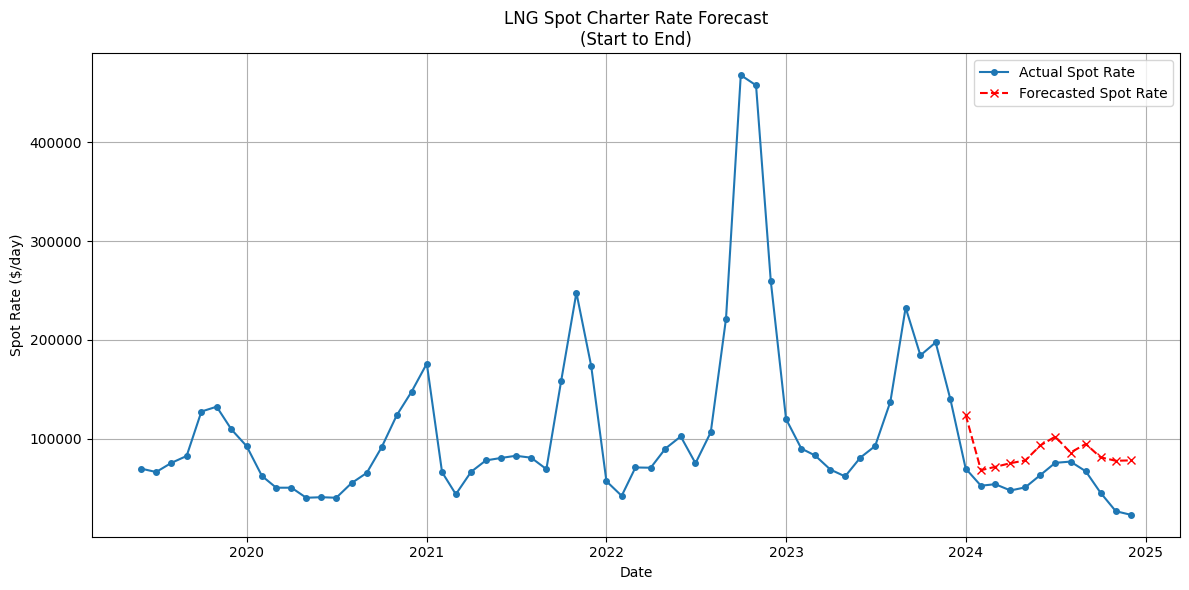

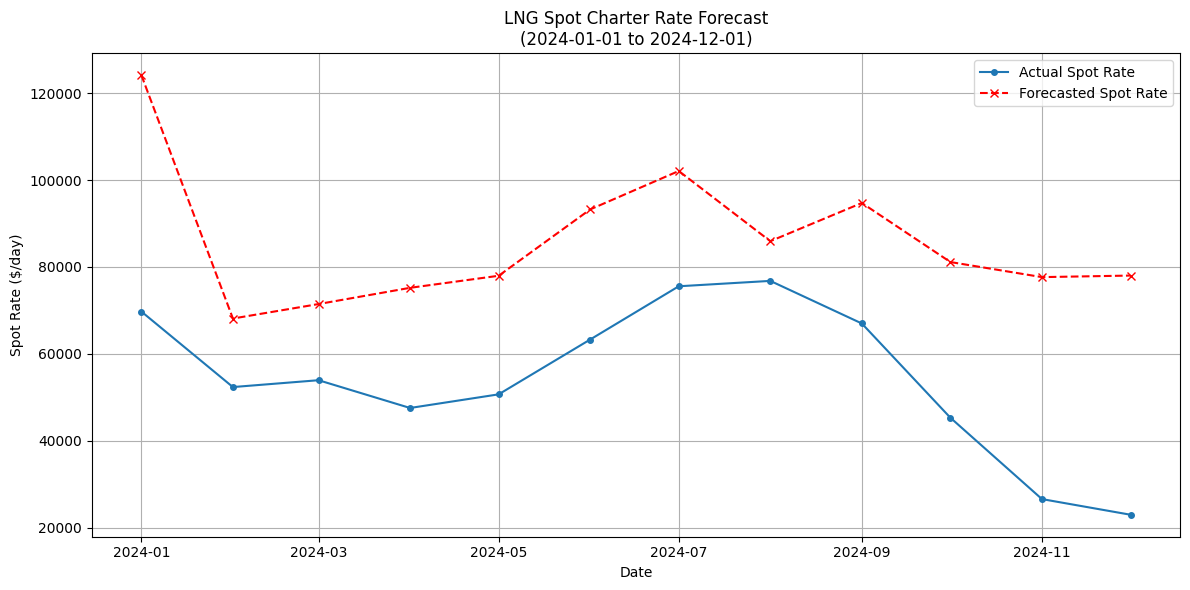

In [4]:
# Plot full dataset
plot_spot_rates(forecast_export)


# Plot forecast only
plot_spot_rates(forecast_export, start_date='2024-01-01', end_date='2024-12-01')


 Forecast Comparison (MAE and RMSE):
Naive - Last Value        | MAE: $85,422.92 | RMSE: $87,031.79
Naive - 6M Lag            | MAE: $63,061.46 | RMSE: $86,051.51
Naive - 3M Rolling Avg    | MAE: $31,067.71 | RMSE: $43,299.15


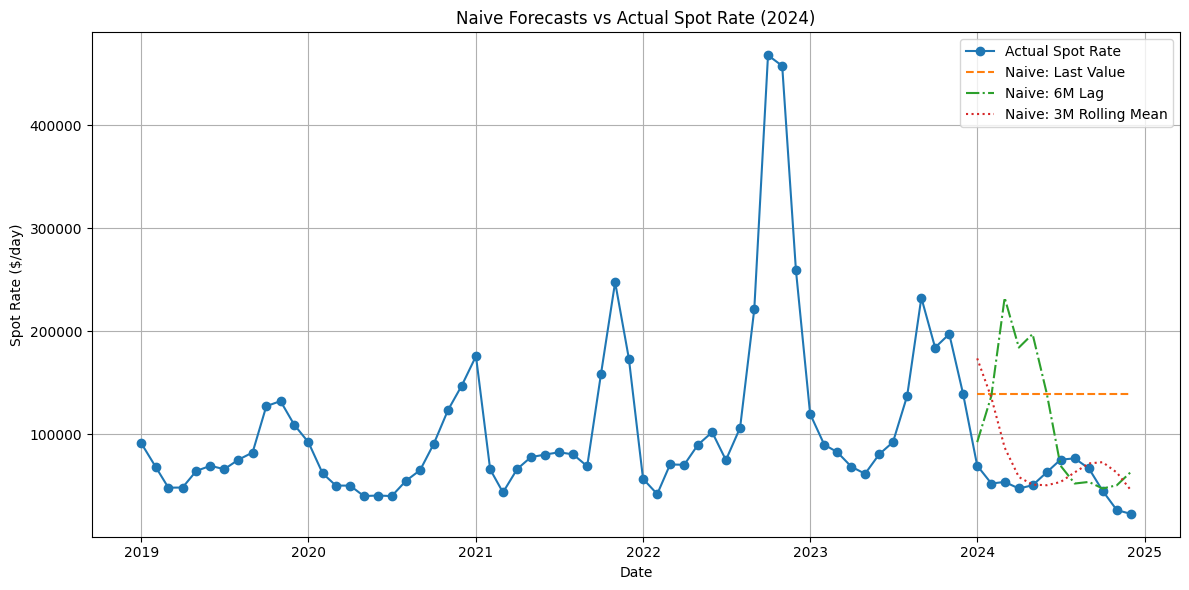

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# --- Baseline 1: Classic Naive (last value)
last_val = df_train[target].iloc[-1]
naive_last = pd.Series(last_val, index=y_test.index)

# --- Baseline 2: 6-Month Lag
naive_lag6 = df_clean[target].shift(6).loc[y_test.index]

# --- Baseline 3: 3-Month Rolling Mean
naive_roll3 = df_clean[target].rolling(3).mean().shift(1).loc[y_test.index]

# --- Evaluation
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

results = {
    "Naive - Last Value": evaluate_forecast(y_test, naive_last),
    "Naive - 6M Lag": evaluate_forecast(y_test, naive_lag6),
    "Naive - 3M Rolling Avg": evaluate_forecast(y_test, naive_roll3)
}

# --- Print Comparison Table
print(" Forecast Comparison (MAE and RMSE):")
for name, (mae, rmse) in results.items():
    print(f"{name:25} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

# --- Plot All
plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, df_clean[target], label='Actual Spot Rate', marker='o')
#plt.plot(y_test.index, y_test.values, label='Actual Spot Rate', marker='o')
plt.plot(naive_last.index, naive_last.values, label='Naive: Last Value', linestyle='--')
plt.plot(naive_lag6.index, naive_lag6.values, label='Naive: 6M Lag', linestyle='-.')
plt.plot(naive_roll3.index, naive_roll3.values, label='Naive: 3M Rolling Mean', linestyle=':')
plt.title("Naive Forecasts vs Actual Spot Rate (2024)")
plt.ylabel("Spot Rate ($/day)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
